## Portfolio Part 3

In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the rating column has been changed with like or dislike values. Your task is to train classification models to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item| rating | helpfulness | gender | category |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __timestamp__ - the timestamp indicating when the user rated the shopping item
* __review__ - the user's review comments of the item
* __item__ - the name of the item
* __rating__ - the user like or dislike the item
* __helpfulness__ - average rating from other users on whether the review comment is helpful. 6-helpful, 0-not helpful. 
* __gender__ - the gender of the user, F- female, M-male
* __category__ - the category of the shopping item


Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the __rating__ field in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
import os
import math
from collections import Counter
from sklearn import metrics


%matplotlib inline

In [2]:
df = pd.read_csv('Portfolio 3.csv')
df.head(10)

,userId,timestamp,review,item,rating,helpfulness,gender,category
0,4259,11900,"Finally, Something for (Relatively) Nothing",MyPoints.com,like,4,F,Online Stores & Services
1,4259,12000,Shocking!,Sixth Sense,like,4,F,Movies
2,4259,12000,Simply Shaggadelic!,Austin Powers: The Spy Who Shagged Me,like,4,F,Movies
3,4259,12000,Better Than The First!,Toy Story 2,like,3,F,Movies
4,4259,12000,Blair Witch made me appreciate this,Star Wars Episode I: The Phantom Menace,dislike,4,F,Movies
5,4259,12100,Come here at least once in your life... stay a...,New York City,like,4,F,Hotels & Travel
6,4259,12400,"I joined for the free camera, and stood for no...",Earthlink,like,3,F,Online Stores & Services
7,4259,12700,They Should've Fooled the American Public,Blair Witch Project,dislike,4,F,Movies
8,4259,51600,A Short List of Things to Remember in NYC,New York City,like,4,F,Hotels & Travel
9,4259,60200,Do you know what a metaphysical can of worms t...,Being John Malkovich,like,4,F,Movies


In [3]:
# Converting object features into digit features to find outliers 

# Gender= gender_code
# Category= category_code
# Review= review_code
# Rating= rating_code

from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder(dtype=int)
df[["gender", "category", "review", "rating", "item"]] = ord_enc.fit_transform(df[["gender", "category", "review", "rating", "item"]])
df[["gender", "category", "review", "rating", "item",]].head(11)

,gender,category,review,rating,item
0,0,6,856,1,43
1,0,5,1985,1,62
2,0,5,2006,1,9
3,0,5,472,1,77
4,0,5,493,0,68
5,0,2,599,1,47
6,0,6,1232,1,23
7,0,5,2415,0,12
8,0,2,136,1,47
9,0,5,692,1,11


In [4]:
# Overview of the dataset after converting categorical values into numerical values
df.head()

,userId,timestamp,review,item,rating,helpfulness,gender,category
0,4259,11900,856,43,1,4,0,6
1,4259,12000,1985,62,1,4,0,5
2,4259,12000,2006,9,1,4,0,5
3,4259,12000,472,77,1,3,0,5
4,4259,12000,493,68,0,4,0,5


(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, 'userId'),
  Text(2, 0, 'timestamp'),
  Text(3, 0, 'review'),
  Text(4, 0, 'item'),
  Text(5, 0, 'rating'),
  Text(6, 0, 'helpfulness'),
  Text(7, 0, 'gender'),
  Text(8, 0, 'category')])

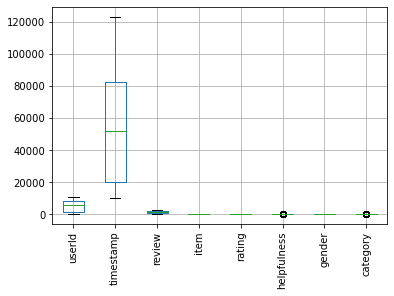

In [5]:
# Finding outliers

df.boxplot()
plt.xticks(rotation=90)

# The code extracting outliers in the category feature because majority is 'Movies'. We'll need to avoid this as removing these outliers would remove most of the dataset which is not ideal.

In [6]:
# Counting and dropping null values

df.isna().sum()

# No null values 

userId         0
timestamp      0
review         0
item           0
rating         0
helpfulness    0
gender         0
category       0
dtype: int64

In [7]:
# Finding correlation between features

df.corr()

,userId,timestamp,review,item,rating,helpfulness,gender,category
userId,1.000000,-0.036399,0.013212,-0.002618,0.010844,-0.016841,0.056183,0.015408
timestamp,-0.036399,1.000000,-0.025036,0.024337,0.011579,0.003638,-0.049244,0.037118
review,0.013212,-0.025036,1.000000,0.168119,-0.046935,0.016170,-0.014422,0.012047
item,-0.002618,0.024337,0.168119,1.000000,0.013629,-0.010780,0.006231,-0.054699
rating,0.010844,0.011579,-0.046935,0.013629,1.000000,-0.016850,0.022576,-0.116312
helpfulness,-0.016841,0.003638,0.016170,-0.010780,-0.016850,1.000000,-0.046627,-0.000189
gender,0.056183,-0.049244,-0.014422,0.006231,0.022576,-0.046627,1.000000,-0.017644
category,0.015408,0.037118,0.012047,-0.054699,-0.116312,-0.000189,-0.017644,1.000000


AxesSubplot(0.125,0.125;0.62x0.755)


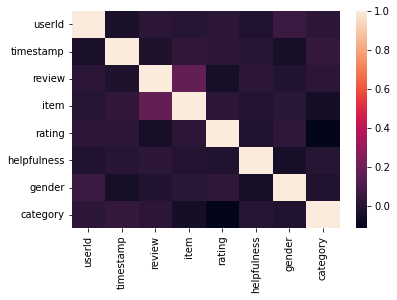

In [8]:
df1= sns.heatmap(df.corr())
print(df1)

### Correlation Analysis

Most correlated features- Review and Item



Least correlated features- Category & Helpfulness

In [9]:
# Splitting train and test sets

train, test= train_test_split(df, test_size=0.2, random_state=0)
print("Train shape-", train.shape)
print("Test shape-", test.shape)

Train shape- (2319, 8)
Test shape- (580, 8)


In [10]:
# Training the Regression model with most important features

X_train = train[['review', 'item', 'gender', 'category', 'helpfulness']]
y_train = train['rating']

X_test = test[['review', 'item', 'gender', 'category', 'helpfulness']]
y_test = test['rating']


model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [11]:
# Analysing the accuracy of the Regression model

reg = linear_model.LogisticRegression()
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
mse = ((np.array(y_test)-predicted)**2).sum()/len(y_test)
r2 = r2_score(y_test, predicted)
print("MSE:", mse)
print("Root MSE:", np.sqrt(mse))
print("R Squared:", r2)
print("Accuracy score:", accuracy_score(y_test, predicted))

MSE: 0.3741379310344828
Root MSE: 0.6116681543406381
R Squared: -0.6100599966739584
Accuracy score: 0.6258620689655172


In [12]:
# Training the KNN model

# Creating KNN classifier
knn5 = KNeighborsClassifier(n_neighbors=5)

# Fit the classifier to the data
knn5.fit(X_train,y_train)


KNeighborsClassifier()

In [13]:
# Predicting test data set
y_pred = model.predict(X_test)

# Checking the performance of our model with classification report.
print(classification_report(y_test, y_pred))

# Checking the performance of our model with ROC Score.
roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.17      0.00      0.01       213
           1       0.63      0.99      0.77       367

    accuracy                           0.63       580
   macro avg       0.40      0.50      0.39       580
weighted avg       0.46      0.63      0.49       580



0.49553542873955814

In [17]:
# Hyperparameter that we want to tune
parameter_grid = {"n_neighbors" : range(1,100)}


# Create new KNN object
knn_best = KNeighborsClassifier()

# Using GridsearchCV
knn_best_tune= GridSearchCV(knn_best, parameter_grid, scoring = "accuracy", cv = 5)

# Fitting the classifier into the data
knn_best_tune.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100)}, scoring='accuracy')

In [18]:
# Printing the value of best Hyperparameter

knn_best_tune.best_params_

{'n_neighbors': 92}

In [19]:
# New accuracy score

knn_best_tune.best_score_

0.6395006330528041

### Conclusion Analysis
- Both the models have their advantages and disadvantages.
- From the Logistic regression model, we get the accuracy score of- 62%
- From the KNN model with neihbor= 5, we get the score of around 50%
- After tuning the hyperparameter(K), in our KNN model, we get the accuracy score of around 64%

- Very little improvement compared to Logistic Regression model, and a decent accuracy overall.
- However, based on the hyperparameters with best score, we know it's possible to achieve an accuracy score of 64%.
- In comparision, the KNN model produced the least accuracy score as compared to our Logistic Regression model.
- Overall, hyperparameters are able to help increase the accuracy score of our models and predict the dataset better.